In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm
from scipy.stats import pareto

In [2]:

#ESTO PARA NUESTRO PROBLEMA

alpha = 0.15
#Trabajaremos con estos datos
m = 50
T = np.linspace(0.05, 1, num=m)



T2 = np.linspace(0.05, 1, num=501)



# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)


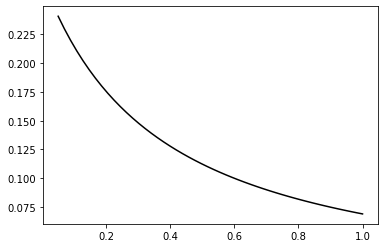

In [3]:

betaT=pd.read_csv("betaT_dec.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("betaT2_dec.csv", header=None )
betaT2=np.array(betaT2).squeeze()

plt.plot(T,betaT, 'k-')
plt.show()

In [6]:
#Trabajaremos con estos datos



## ERROR SIGUE UNA $N(0, 0.01)$

### Gráficos

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_dec', str(i+1), str(N)])
        tttt="_".join(['y_dec', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red')
        plt.ylim([0.05, 0.3])
        plt.legend()
        plt.show()
        plt.figure(figsize=(3,4))
        plt.plot(np.linspace(0,1, num=len(y)), y, label = 'True y')
        plt.plot(np.linspace(0,1, num=len(y_hat)), y_hat, label=f'approx {i+1}')
        plt.axhline(0, color='red')
        plt.ylim([0.05, 0.3])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE.sum()/n_sims*1000)
    print(sem(IMSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Cálculo del IMSE y del MSE

IMSE for N= 35 0.07147456757302238
MSE for N= 35 0.21926731524965531
Standard deviation of the IMSE: 3.861027058063453e-06
Standard deviation of the MSE: 3.592013821770199e-06
3.861027058063453e-06
IMSE for N= 75 0.0316409511286308
MSE for N= 75 0.2299032121132183
Standard deviation of the IMSE: 1.6178313704212863e-06
Standard deviation of the MSE: 2.785169482727234e-06
1.6178313704212863e-06
IMSE for N= 125 0.02112470306697849
MSE for N= 125 0.2340687896158125
Standard deviation of the IMSE: 9.03832989232478e-07
Standard deviation of the MSE: 2.336887556879135e-06
9.03832989232478e-07


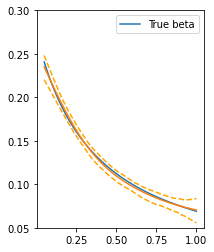

Times [101.70130634 205.33995366 337.41207719]


In [10]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons=np.zeros(n_sims)
MSE_uncons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    for i in range(n_sims):
        ssss="_".join(['X_dec001', str(i+1), str(N)])
        tttt="_".join(['y_dec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
        # plt.figure()
        # plt.plot(T,betaT)
        # plt.plot(T2, betagorro)
        # plt.show()
        #IMSE
        IMSE_uncons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons))
    print('Standard deviation of the MSE:', sem(MSE_uncons))
    print(sem(IMSE_uncons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

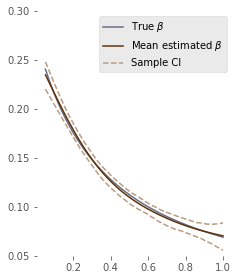

In [111]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_decreceuncons001.png', transparent=True)
plt.show()

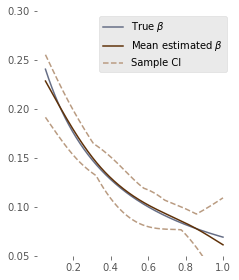

In [116]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_decreceuncons005.png', transparent=True)
plt.show()

## ERROR SIGUE UNA $N(0, 0.05)$

IMSE for N= 35 0.6385223503519394
MSE for N= 35 2.290720192250993
Standard deviation of the IMSE: 3.675509684763444e-05
Standard deviation of the MSE: 5.860117474346453e-05
IMSE for N= 75 0.3097217430420539
MSE for N= 75 2.2985314613650276
Standard deviation of the IMSE: 1.5991653514640915e-05
Standard deviation of the MSE: 3.0153157873439152e-05
IMSE for N= 125 0.16204958901728678
MSE for N= 125 2.395249715641276
Standard deviation of the IMSE: 5.260793386642512e-06
Standard deviation of the MSE: 2.2651339009223323e-05


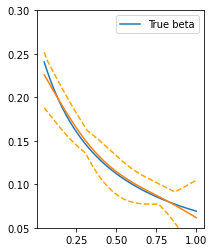

Times [100.1530354  217.03000116 322.78751636]


In [15]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons005=np.zeros(n_sims)
MSE_uncons005=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_dec', str(i+1), str(N)])
        tttt="_".join(['y_dec', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons005[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons005[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons005.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons005.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons005))
    print('Standard deviation of the MSE:', sem(MSE_uncons005))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

## CONSTRAINED: ERROR SIGUE UNA $N(0, 0.01)$

### Plots

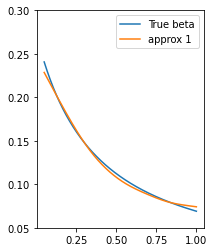

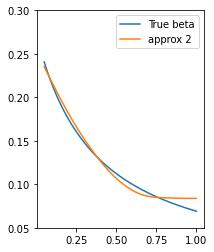

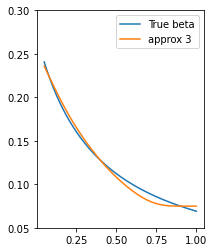

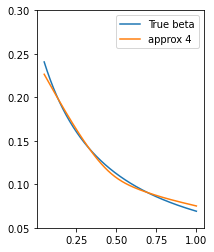

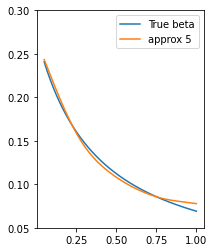

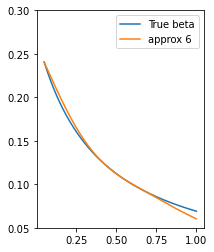

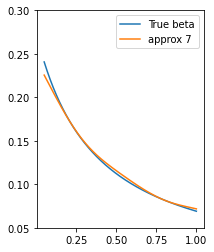

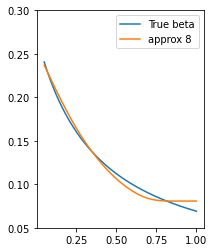

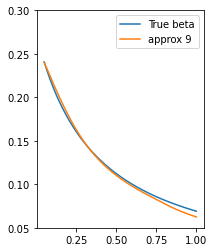

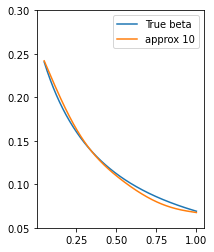

IMSE for N= 125 0.018783584564224028
MSE for N= 125 0.23787695388694036
Standard deviation of the IMSE: 2.796213087658881e-06
Standard deviation of the MSE: 1.225458789741425e-05


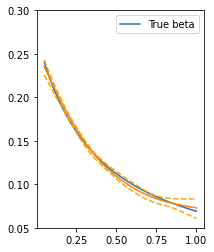

Times [19.46390772  0.          0.        ]


In [11]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_dec001', str(i+1), str(N)])
        tttt="_".join(['y_dec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=1, sign='-', sign_threshold=0.0,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([0.05, 0.3])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons))
    print('Standard deviation of the MSE:', sem(MSE_cons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

### Cálculo del IMSE y del MSE

IMSE for N= 35 0.07080693832937597
MSE for N= 35 0.2194256933443088
Standard deviation of the IMSE: 3.850595065216384e-06
Standard deviation of the MSE: 3.5892746132792886e-06
IMSE for N= 75 0.031049481173684414
MSE for N= 75 0.23004786643130773
Standard deviation of the IMSE: 1.577202598993036e-06
Standard deviation of the MSE: 2.783853191826933e-06
IMSE for N= 125 0.02067016732769745
MSE for N= 125 0.2342091237545812
Standard deviation of the IMSE: 8.892481145058932e-07
Standard deviation of the MSE: 2.3355867719789063e-06


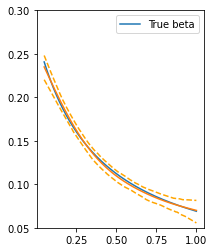

Times [ 96.81395078 220.34858108 379.78999829]


In [28]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_constrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_dec001', str(i+1), str(N)])
        tttt="_".join(['y_dec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=1, sign='-', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons))
    print('Standard deviation of the MSE:', sem(MSE_cons))
    end_time = time.time()
    time_constrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_constrained)

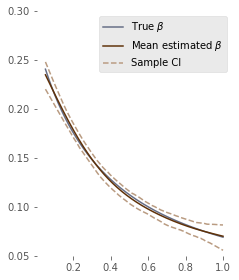

In [114]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_decrece_cons001.png', transparent=True)
plt.show()

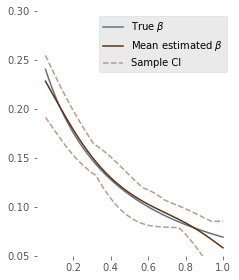

In [118]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_decrece_cons005.png', transparent=True)
plt.show()

In [22]:
mse_uncons001_pareto_dec_ellos = np.array([0.09693308, 0.08799850, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446,
0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446, 0.09468446])

imse_uncons001_pareto_dec_ellos = np.array([00.42245998, 0.38627251, 0.52393605, 0.54990608, 0.50023339,
0.51551303, 0.4486451 , 0.48801403, 0.52646758, 0.54604433,  0.50446701, 0.57460977, 0.56572658, 0.51109953, 0.44051401,
0.45959211, 0.48958334, 0.54639433, 0.52222727, 0.45009167,  0.50605613, 0.56131994, 0.50167496, 0.49042001, 0.57455782,
0.51452139, 0.49854439, 0.52342411, 0.51343404, 0.50004483,  0.54917279, 0.54639015, 0.53814495, 0.50983248, 0.54732611,
0.51142802, 0.5269184 , 0.54392971, 0.53718443, 0.56661174,  0.52645762, 0.4623973 , 0.478114  , 0.5534223 , 0.5029806 ,
0.52451527, 0.48737543, 0.54294554, 0.50137413, 0.55666235,  0.49695208, 0.5464631 , 0.53315098, 0.49124734, 0.54588899,
0.48587007, 0.48824508, 0.53457044, 0.49415884, 0.49510381,  0.50260208, 0.48291402, 0.54426893, 0.53117454, 0.51083924,
0.50966734, 0.52642377, 0.56587915, 0.53904819, 0.49766539,  0.53624168, 0.50935596, 0.50694915, 0.56891324, 0.50035096,
0.49854355, 0.45435594, 0.47084923, 0.52645279, 0.49207147,  0.52838151, 0.47947297, 0.48989981, 0.53315622, 0.55674587,
0.53069328, 0.54885403, 0.56405693, 0.54412177, 0.4853659 ,  0.50975876, 0.53182497, 0.50047369, 0.52647748, 0.46554441,
0.48806026, 0.52878549, 0.4458065 , 0.47968772, 0.51238755,  0.46133727, 0.51463273, 0.48893268, 0.50417126, 0.50514961,
0.5185979 , 0.49600544, 0.51560969, 0.4948844 , 0.52960131,  0.56373337, 0.51882519, 0.51801518, 0.47799886, 0.53372009,
0.49017708, 0.48865368, 0.52964228, 0.51835026, 0.54613436,  0.55620541, 0.49672865, 0.51677041, 0.56573156, 0.54191528,
0.53431057, 0.55210528, 0.49478101, 0.5320166 , 0.5551967 ,  0.56154647, 0.48873356, 0.50536887, 0.52440056, 0.50424918,
0.50116461, 0.53343914, 0.5023168 , 0.45928171, 0.52377452,  0.50018432, 0.49097317, 0.46594696, 0.54333377, 0.44610572,
0.46193909, 0.50464372, 0.54978777, 0.55221028, 0.47826962,  0.50759013, 0.46760541, 0.54325531, 0.46862222, 0.50862323,
0.54390861, 0.50624668, 0.55702391, 0.48681885, 0.52399481,  0.53851757, 0.50872775, 0.55450853, 0.52936299, 0.46379561,   
0.63167718, 0.53237841, 0.5161394 , 0.47095472, 0.51537213,  0.49912082, 0.53224971, 0.52406921, 0.56850938, 0.51718664,   
0.52832426, 0.52409281, 0.50846441, 0.50741709, 0.54594911,  0.53631991, 0.49403585, 0.47951602, 0.5108968 , 0.5477623 , 
0.51209322, 0.56531215, 0.48966699, 0.51716832, 0.43742998,  0.49504906, 0.50364546, 0.52824723, 0.56423896, 0.51396741,  
0.55653663, 0.53276953, 0.54250967, 0.49893445, 0.55446884])


mse_cons001_pareto_dec_ellos = np.array([0.08712461, 0.09545229, 0.09163256, 0.08171985, 0.09198625, 0.08871053, 0.09751453, 0.09551541, 0.09012200, 0.10529385, 0.08856267, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797,
0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688,
0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191,
0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020,
0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344,
0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654,
0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895,
0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797,
0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688,
0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191,
0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020,
0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.09644020, 0.08614688, 0.09242895, 0.08270344, 0.10176191, 0.08570797, 0.08873654, 0.11035707, 0.08474674, 0.08539743, 0.15378260,
0.13949407, 0.10434330, 0.07301598, 0.08049194, 0.12630954, 0.10436614, 0.13555564, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440])


imse_cons001_pareto_dec_ellos = np.array([0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441,
0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578,
0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028,
0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242,
0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346,
0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183,
0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440,
0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441,
0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578,
0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028,
0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346, 0.13337028, 0.14607441, 0.09183183, 0.15930242, 0.09619578, 0.08564440, 0.12913346])

In [19]:
mse_uncons005_pareto_dec_ellos = np.array([1.729070,2.391982,2.404449,2.692799, 2.425045, 2.262371, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951,
2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751, 2.257645, 2.659951, 2.480546, 2.397751,
2.257645, 2.659951, 2.480546, 2.397751])

imse_uncons005_pareto_dec_ellos = np.array([ 0.5343352, 3.6575107, 0.2522383, 1.0249679, 0.6203939,    1.7012498, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306 ,0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004,
6.1257738, 0.7121675, 0.7405306, 0.1318004, 6.1257738, 0.7121675, 0.7405306, 0.1318004])


mse_cons005_pareto_dec_ellos = np.array([2.439865,2.088064, 2.294199, 2.585479, 1.812049, 2.566344, 1.869435, 2.422187, 2.158946, 2.544463, 2.206987 ,2.197194, 2.034843 ,1.912056, 1.966239, 1.750607 ,3.054233, 2.255956, 2.137439, 2.323967, 2.564921,
1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921 ,1.901995, 2.562017 ,2.146159, 2.544463, 2.206987 ,2.197194,
2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194 ,2.034843, 1.912056 ,1.966239, 1.750607, 3.054233 ,2.255956,
2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956 ,2.137439, 2.323967 ,2.564921, 1.901995, 2.562017 ,2.146159,
2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159 ,2.544463, 2.206987 ,2.197194, 2.034843, 1.912056 ,1.966239,
1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239 ,1.750607, 3.054233 ,2.255956, 2.137439, 2.323967 ,2.564921,
1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921 ,1.901995, 2.562017 ,2.146159, 2.544463, 2.206987 ,2.197194,
2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194 ,2.034843, 1.912056 ,1.966239, 1.750607, 3.054233 ,2.255956,
2.137439, 2.323967, 2.564921, 1.901995, 2.562017, 2.146159, 2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956 ,2.137439, 2.323967 ,2.564921, 1.901995, 2.562017 ,2.146159,
2.544463, 2.206987, 2.197194, 2.034843, 1.912056, 1.966239, 1.750607, 3.054233, 2.255956, 2.137439, 2.323967])


imse_cons005_pareto_dec_ellos = np.array([0.39143387,0.47006884, 0.12802718,0.30688089, 0.06959824, 0.23517409, 0.36853617, 0.17619266, 0.34544367, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480,
0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988,
0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080,
0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055,
0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939,
0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092,
0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521,
0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768,
0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121,
0.25778988, 0.15307973, 0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973,
0.22852080, 0.13157405, 0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973, 0.22852080, 0.13157405,
0.12344055, 0.32168432, 0.51328939, 0.37817506, 0.43077092, 0.70763685, 0.09812521, 0.06508703, 0.65287768, 0.22068480, 0.64825121, 0.25778988, 0.15307973])


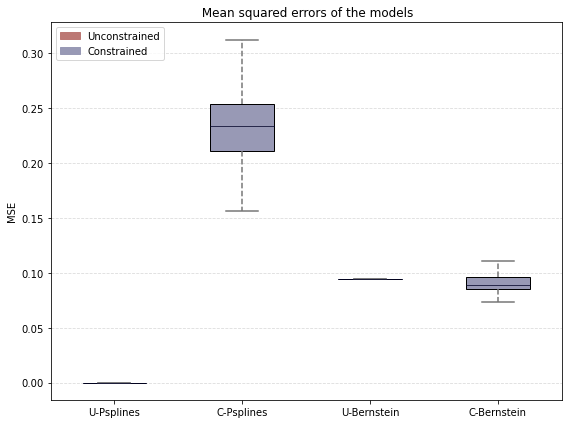

In [24]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC7874', '#9899B5', '#BC7874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([MSE_cons*1000, MSE_uncons*1000, mse_uncons001_pareto_dec_ellos, mse_cons001_pareto_dec_ellos], patch_artist=True, widths=0.5, showfliers=False)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#03052A', linewidth=0.75)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('MSE')
ax.set_title(' Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)

plt.savefig('pareto_dec_msesegundoNOLOSAQUES ESTA MAL EL MSE.png', transparent=True)
# Show the plot
plt.show()

### CONSTRAINED: ERROR SIGUE UNA $N(0, 0.05)$

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_constrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_dec', str(i+1), str(N)])
        tttt="_".join(['y_dec', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=1, sign='-', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE_cons))
    end_time = time.time()
    time_constrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_constrained)

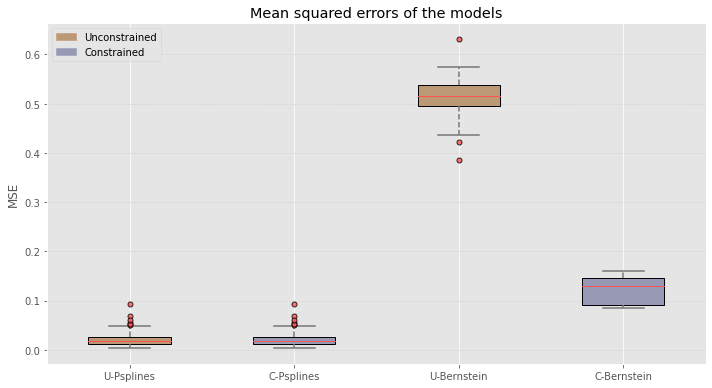

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np



# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5.5))
# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([IMSE_uncons*1000, IMSE_cons*1000, imse_uncons001_pareto_dec_ellos, imse_cons001_pareto_dec_ellos], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('MSE')
ax.set_title('Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('pareto_dec_imse(bueno)_001.png', transparent=True)
# Show the plot
plt.show()